In [44]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import re
import glob
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import datetime as dt

from scipy.constants import speed_of_light

c = speed_of_light

sps = 10e6 # 10 Msps

%matplotlib inline
%config InlineBackend.close_figures=True

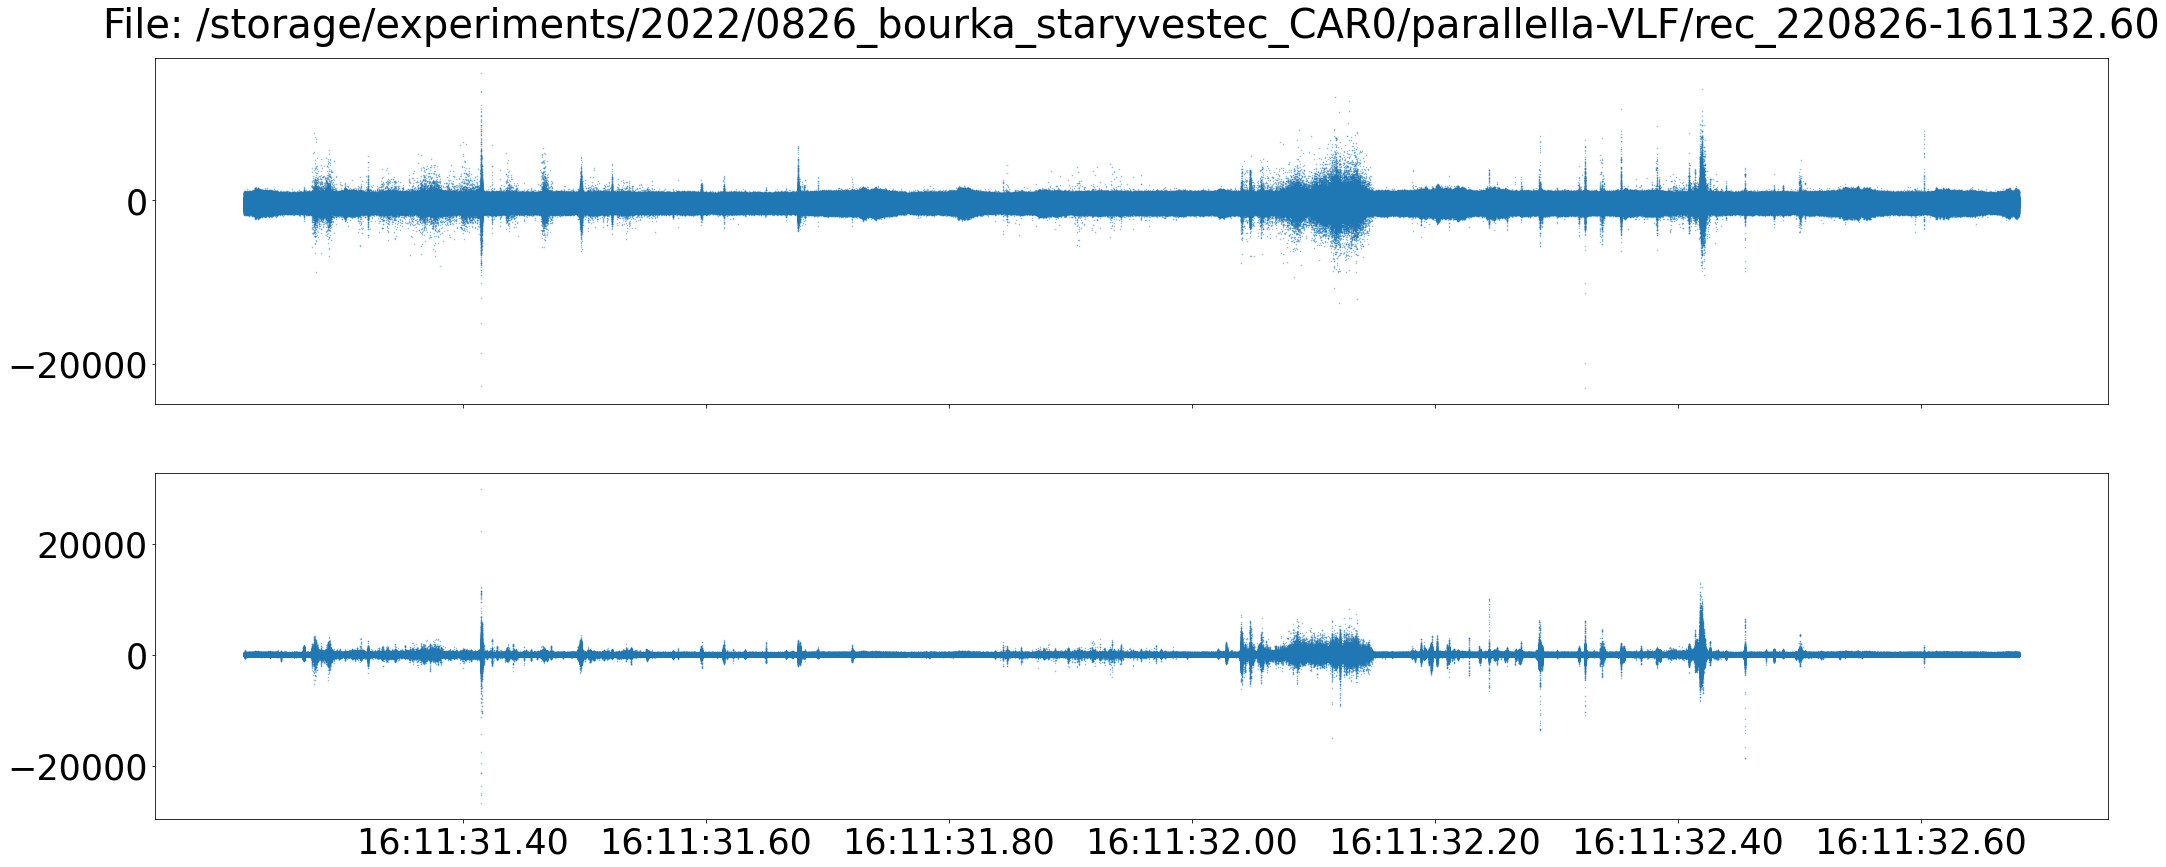

In [42]:

filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/parallella-VLF/rec_220826-161132.60'

channels = [1,3]
nrows = len(channels) * 1
fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)

mintime = None
data = []

# Load and process data
try:
    with open(filepath, 'rb') as file:
        fn = os.path.basename(filepath)
        h, samples, synclog = loadrec(file)
        t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

        time = s2t(0)
        mintime = time if mintime is None else min(mintime, time)

        # Add data to the list for later processing
        data.append((filepath, h, samples, synclog, t2s, s2t, ticker, formatter))
except Exception as e:
    print(f"Exception: {e}")

# Render data
ax_idx = 0
for i, (filepath, h, samples, synclog, t2s, s2t, ticker, formatter) in enumerate(data):
    offset = -int(t2s(mintime))

    # Use full path for the file label only once above the first channel
    axs[ax_idx].set_title(f"File: {filepath}", fontsize=40, pad=20)

    a = (h['preTrigger'] - h['preTrigger']) * h['descSpan'] // 16
    b = (h['preTrigger'] + h['postTrigger']) * h['descSpan'] // 16
    for ch in channels:
        signal_samples = samples[a:b, ch]

        axs[ax_idx].xaxis.set_major_locator(ticker)
        axs[ax_idx].xaxis.set_major_formatter(formatter)
        axs[ax_idx].plot(range(a + offset, b + offset), signal_samples, linestyle="", marker=".", alpha=0.5, markersize=1)

        axs[ax_idx].tick_params(axis='x', which='major', labelsize=35)
        axs[ax_idx].tick_params(axis='y', which='major', labelsize=35)

        ax_idx += 1


plt.show()

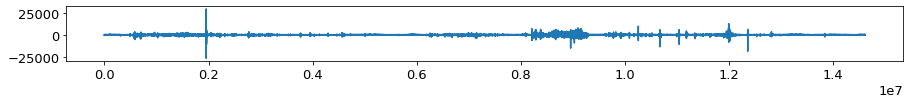

interactive(children=(IntSlider(value=0, description='fromx', layout=Layout(width='800px'), max=14604528), Int…

<function __main__.plot_graph(fromx, samples)>

In [9]:
plt.rcParams.update({'font.size': 13})
fig, (ax) = plt.subplots(nrows=1, sharex=True, figsize=(15,1))
#plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax.plot(signal_samples)
plt.show()

def plot_graph_zoom(fromxzoom, sampleszoom):
    fig, (ax) = plt.subplots(nrows=1, sharex=True, figsize=(15,5))
    ax.plot(range(fromxzoom,fromxzoom+sampleszoom), signal_samples[fromxzoom:fromxzoom+sampleszoom])
    plt.show()
    
def plot_graph(fromx, samples):
    if ((fromx+samples)>len(signal_samples)):
        samples = len(signal_samples)-fromx
    fig, (ax) = plt.subplots(nrows=1, sharex=True, figsize=(15,2))
    ax.plot(range(fromx,fromx+samples), signal_samples[fromx:fromx+samples])
    plt.show()
    interact(plot_graph_zoom, 
             fromxzoom=widgets.IntSlider(min=fromx, max=fromx+samples, step=1, value=fromx, layout=widgets.Layout(width='800px')), 
             sampleszoom=widgets.IntSlider(min=1000, max=int(samples/4), step=1, value=int(samples/4), layout=widgets.Layout(width='800px')), 
            )
    
interact(plot_graph, 
         fromx=widgets.IntSlider(min=0, max=len(signal_samples)-10000, step=1, value=0, layout=widgets.Layout(width='800px')), 
         samples=widgets.IntSlider(min=10000, max=int(len(signal_samples)/4), step=1, value=int(len(signal_samples)/4), layout=widgets.Layout(width='800px')), 
        )

/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos/2022-08-26-16-11-32.607715-lightning.mp4.csv
2022-08-26 16:11:32.607715


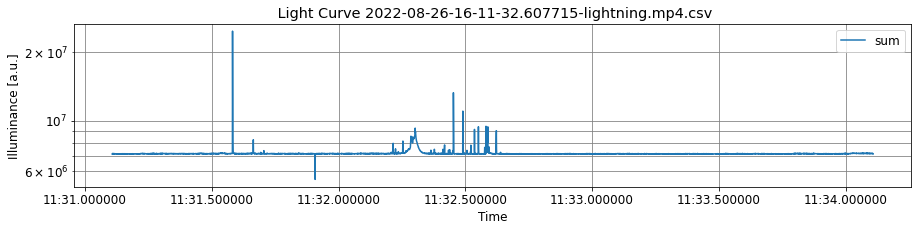

In [131]:
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0'

for f in glob.iglob(directory + "/chronos/*16-11-32.607715-lightning.mp4.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')
        st = s[len(s)-1]
        print(f)
        y = pd.read_csv(f)
        
        trigger = pd.to_datetime(st.split('-l')[0],format='%Y-%m-%d-%H-%M-%S.%f')
        print(trigger)

        y['time'] = trigger + pd.to_timedelta(y.index * 0.000620220426339521 - 1.5, unit='s') # in seconds
        plt.figure(figsize=(15,3))
        plt.rc('font', size=12)    

        plt.plot(y['time'], y['0'], label='sum')
        plt.legend(loc=2)
        
        plt.yscale('log')
        plt.title(' Light Curve ' + st)
        plt.xlabel('Time')
        plt.ylabel('Illuminance [a.u.]')
        plt.grid(visible=True, which='major', color='grey', linestyle='-')
        plt.grid(visible=True, which='minor', color='grey', linestyle='-')
        plt.legend()
        plt.show()

    except:
        pass


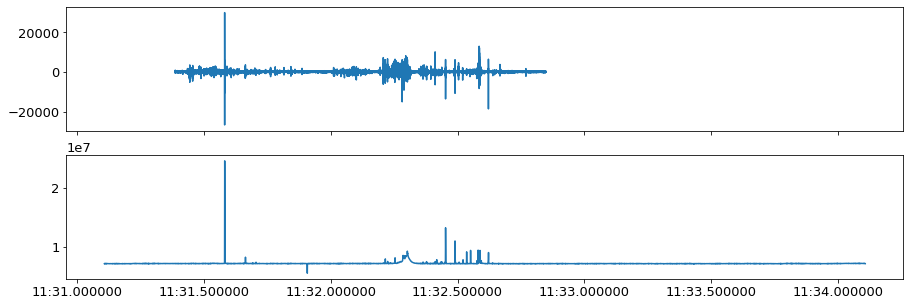

In [120]:
plt.rcParams.update({'font.size': 13})
fig, (ax) = plt.subplots(nrows=2, sharex=True, figsize=(15,5))

signal = pd.DataFrame(signal_samples)

# ten offset triggeru 1.2215 jsem urcil experimentalne
signal['time'] = trigger + pd.to_timedelta(signal.index * 1/sps - 1.2215, unit='s') # in seconds


ax[0].plot(signal['time'],signal[0])
ax[1].plot(y['time'], y['0'], label='sum')
plt.show()


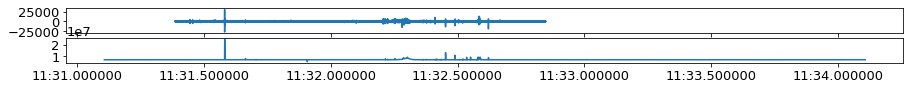

interactive(children=(IntSlider(value=-1200, description='fromx', layout=Layout(width='800px'), max=200, min=-…

<function __main__.plot_graph(fromx, tox)>

In [132]:
plt.rcParams.update({'font.size': 13})
fig, (ax) = plt.subplots(nrows=2, sharex=True, figsize=(15,1))
ax[0].plot(signal['time'],signal[0])
ax[1].plot(y['time'], y['0'], label='sum')
plt.show()

signal.set_index('time', inplace=True, drop=False)
y.set_index('time', inplace=True, drop=False)

def plot_graph(fromx, tox):
    global od
    global do
    fromtime = trigger + pd.to_timedelta(fromx, unit='ms')
    totime = trigger + pd.to_timedelta(tox, unit='ms')
    fig, (ax) = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
    ax[0].plot(signal.loc[fromtime:totime]['time'],signal.loc[fromtime:totime][0], label='antenna')
    ax[1].plot(y.loc[fromtime:totime]['time'], y.loc[fromtime:totime]['0'], label='camera')
    plt.show()
    od = fromx
    do = tox
    
interact(plot_graph, 
         fromx=widgets.IntSlider(min=-1200, max=200, step=1, value=-1200, layout=widgets.Layout(width='800px')), 
         tox=widgets.IntSlider(min=-1200, max=200, step=1, value=200, layout=widgets.Layout(width='800px')),  
        )

In [135]:
plt.rcParams.update({'font.size': 13})

signal.set_index('time', inplace=True, drop=False)
y.set_index('time', inplace=True, drop=False)

def plot_graph(fromx, tox):
    fromtime = trigger + pd.to_timedelta(fromx, unit='ms')
    totime = trigger + pd.to_timedelta(tox, unit='ms')
    fig, (ax) = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
    ax[0].plot(signal.loc[fromtime:totime]['time'],signal.loc[fromtime:totime][0], label='antenna')
    ax[1].plot(y.loc[fromtime:totime]['time'], y.loc[fromtime:totime]['0'], label='camera', marker='o')
    plt.show()
    
interact(plot_graph, 
         fromx=widgets.IntSlider(min=od, max=do, step=1, value=od, layout=widgets.Layout(width='800px')), 
         tox=widgets.IntSlider(min=od, max=do, step=1, value=do, layout=widgets.Layout(width='800px')),  
        )

interactive(children=(IntSlider(value=-1048, description='fromx', layout=Layout(width='800px'), max=-1001, min…

<function __main__.plot_graph(fromx, tox)>

In [127]:
do


0